# Compare group knockoffs

This simulation adapts the 4th simulation routine in section 5.1 of [Li and Mathius](https://academic.oup.com/jrsssb/article/83/3/534/7056103). Similar to [Spector and Janson](https://projecteuclid.org/journals/annals-of-statistics/volume-50/issue-1/Powerful-knockoffs-via-minimizing-reconstructability/10.1214/21-AOS2104.short), we also define the **ER(cov) and ER(prec)** model, where the first later model uses the precision matrix instead. 

+ target FDR = 10%
+ We generate equi, SDP, MVR, and ME group knockoffs using the true covariance matrix
+ Groups are defined via average linkake hierarchical clustering with cutoff 0.3

Simulation scripts



In [4]:
using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using ProgressMeter
using CSV, DataFrames

# provides extra arguments for controlling CCD/PCA convergence criteria
function get_extra_args(method)
#     tol = occursin("sdp", string(method)) ? 0.00001 : 0.0001
    tol = 0.0001
    niter = 1000
    inner_pca_iter = 1
    inner_ccd_iter = 1
    outer_iter = round(Int, niter / (inner_pca_iter + inner_ccd_iter))
    if method ∈ [:maxent, :mvr]
        return (outer_iter=outer_iter, inner_pca_iter=inner_pca_iter, 
            inner_ccd_iter=inner_ccd_iter, tol=tol)
    elseif method == :sdp # sdp converges slower, so I use more stringent convergence 
        return (outer_iter=outer_iter, inner_pca_iter=inner_pca_iter, 
            inner_ccd_iter=inner_ccd_iter, tol=tol)
    elseif occursin("block", string(method)) # block update
        return (tol=tol, niter=niter)
    else
        return ()
    end
end
function run_group_knockoff_comparison(seed, n, cov::Bool)
    outdir = cov ? "/home/groups/sabatti/group_knockoff_simulations/ER_cov/n$n" : 
        "/home/groups/sabatti/group_knockoff_simulations/ER_prec/n$n"
    isdir(outdir) || mkpath(outdir)
    
    # simulation parameters
    target_fdr = 0.1
    m = 5
    p = 500 # 500
    k = 50
    μ = zeros(p)
    fdr_target = 0.1
    knockoff_methods = [:equi, :sdp, :maxent, :mvr]
#     knockoff_methods = [:equi, :maxent]

    # simulate Σ
    Random.seed!(seed)
    Σ = simulate_ER(p, invert=!cov)

    # simulate X
    L = cholesky(Σ).L
    X = randn(n, p) * L
    zscore!(X, mean(X, dims=1), std(X, dims=1))
    
    # simulate y and beta
    βtrue = zeros(p)
    βtrue[1:k] .= randn(k)
    shuffle!(βtrue)
    ϵ = randn(n)
    y = X * βtrue + ϵ
    
    # define group
    groups = hc_partition_groups(X, cutoff=0.3)
    correct_groups = groups[findall(!iszero, βtrue)] |> unique
    @show length(unique(groups))
    
    df = DataFrame(method = Symbol[], power=Float64[], fdr=Float64[], time=Float64[], ssum=Float64[], obj=Float64[])
    for method in knockoff_methods
        # generate group knockoff
        extra_args = get_extra_args(method)
        Random.seed!(seed)
        my_t = @elapsed ko = modelX_gaussian_group_knockoffs(
            X, method, groups, μ, Σ,
            m=m; extra_args...
        )

        # feature statistic
        ko_filter = fit_lasso(y, ko, fdrs=[fdr_target])
        my_ssum = sum(abs.(ko.S))
        my_obj = ko.obj
        constraint = eigmin(Symmetric((m+1)/m*Σ - ko.S))
        if constraint < -0.0001
            @warn("min eval of (m+1)/m*Σ - S) is less than -0.0001")
        end

        # save output
        selected = ko_filter.selected[1]
        my_power = length(intersect(correct_groups, selected)) / length(correct_groups)
        my_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
        println("sim $seed $method: power = $(my_power), fdr = $(my_fdr), time = $(my_t), ssum = $(my_ssum), obj=$(my_obj), min eval = $constraint")
        push!(df, [method, my_power, my_fdr, my_t, my_ssum, my_obj])
    end
    CSV.write(joinpath(outdir, "sim$seed.csv"), df)
    
    return df
end

# seed = 1112
# cov = true
seed = parse(Int, ARGS[1])
cov = parse(Bool, ARGS[2])
for n in 250:250:1000
    df = run_group_knockoff_comparison(seed, n, cov)
end
println("finished.")


LoadError: ArgumentError: invalid base 10 digit '/' in "/home/users/bbchu/.local/share/jupyter/runtime/kernel-b9b55bfb-97a9-4b09-a13b-48db5709a202.json"

Submission script

In [1]:
function run_repeats(cov::Bool)
    simdir = "/home/groups/sabatti/group_knockoff_simulations"
    outdir = cov ? "/home/groups/sabatti/group_knockoff_simulations/ER_cov" : 
        "/home/groups/sabatti/group_knockoff_simulations/ER_prec"
    for sim in 1:100
        # create .sh file to submit jobs
        filename = "submit.sh"
        open(filename, "w") do io
            println(io, "#!/bin/bash")
            println(io, "#")
            println(io, "#SBATCH --job-name=er_$sim")
            println(io, "#")
            println(io, "#SBATCH --time=24:00:00")
            println(io, "#SBATCH --cpus-per-task=1")
            println(io, "#SBATCH --mem-per-cpu=12G")
            println(io, "#SBATCH --partition=owners,normal,candes,zihuai")
            println(io, "#SBATCH --output=$(outdir)/slurms/slurm-%j.out")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, "module load julia/1.8.4")
            println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia $(simdir)/run_ER.jl $sim $cov'")
            println(io, "julia $(simdir)/run_ER.jl $sim $cov")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
            println(io, "#echo \" \"")
        end
        # submit job
        run(`sbatch $filename`)
        println("submitted sim$sim") 
        rm(filename, force=true)
    end
end
for cov in [true, false]
    run_repeats(cov)
end

Submitted batch job 21447722
submitted sim1
Submitted batch job 21447723
submitted sim2
Submitted batch job 21447725
submitted sim3
Submitted batch job 21447726
submitted sim4
Submitted batch job 21447727
submitted sim5
Submitted batch job 21447728
submitted sim6
Submitted batch job 21447729
submitted sim7
Submitted batch job 21447730
submitted sim8
Submitted batch job 21447731
submitted sim9
Submitted batch job 21447732
submitted sim10
Submitted batch job 21447733
submitted sim11
Submitted batch job 21447734
submitted sim12
Submitted batch job 21447735
submitted sim13
Submitted batch job 21447739
submitted sim14
Submitted batch job 21447740
submitted sim15
Submitted batch job 21447741
submitted sim16
Submitted batch job 21447742
submitted sim17
Submitted batch job 21447743
submitted sim18
Submitted batch job 21447744
submitted sim19
Submitted batch job 21447745
submitted sim20
Submitted batch job 21447746
submitted sim21
Submitted batch job 21447747
submitted sim22
Submitted batch job

Submitted batch job 21447944
submitted sim84
Submitted batch job 21447945
submitted sim85
Submitted batch job 21447946
submitted sim86
Submitted batch job 21447947
submitted sim87
Submitted batch job 21447948
submitted sim88
Submitted batch job 21447949
submitted sim89
Submitted batch job 21447950
submitted sim90
Submitted batch job 21447951
submitted sim91
Submitted batch job 21447952
submitted sim92
Submitted batch job 21447953
submitted sim93
Submitted batch job 21447954
submitted sim94
Submitted batch job 21447955
submitted sim95
Submitted batch job 21447956
submitted sim96
Submitted batch job 21447957
submitted sim97
Submitted batch job 21447958
submitted sim98
Submitted batch job 21447959
submitted sim99
Submitted batch job 21448075
submitted sim100


## Make plots

n 250 has success success
n 500 has success success
n 750 has success success
n 1000 has success success


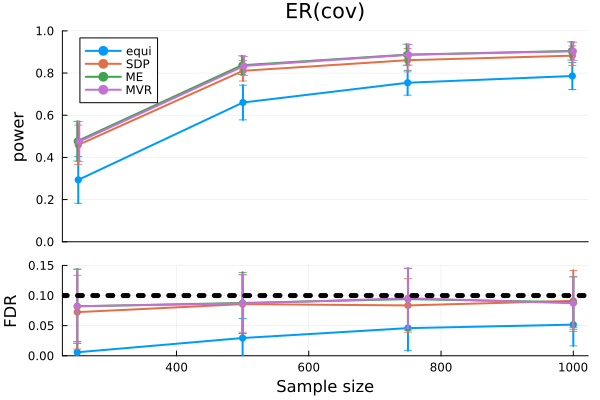

In [3]:
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
using Statistics
gr(fmt=:png);

function summarize_er(cov::Bool, n::Int)
    dir = cov ? "/home/groups/sabatti/group_knockoff_simulations/ER_cov" :
        "/home/groups/sabatti/group_knockoff_simulations/ER_prec"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for seed in 1:100
        try
            result = CSV.read(joinpath(dir, "n$n", "sim$seed.csv"), DataFrame)
            push!(equi_powers, result[1, "power"]); push!(equi_fdrs, result[1, "fdr"])
            push!(sdp_powers, result[2, "power"]); push!(sdp_fdrs, result[2, "fdr"])
            push!(maxent_powers, result[3, "power"]); push!(maxent_fdrs, result[3, "fdr"])
            push!(mvr_powers, result[4, "power"]); push!(mvr_fdrs, result[4, "fdr"])
        catch
            continue
        end
    end
    println("n $n has $success success")
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function make_plot_er(cov::Bool; ns = 250:250:1000)
    equi_powers_mean, equi_fdrs_mean, equi_powers_std, equi_fdrs_std = [], [], [], []
    sdp_powers_mean, sdp_fdrs_mean, sdp_powers_std, sdp_fdrs_std = [], [], [], []
    maxent_powers_mean, maxent_fdrs_mean, maxent_powers_std, maxent_fdrs_std = [], [], [], []
    mvr_powers_mean, mvr_fdrs_mean, mvr_powers_std, mvr_fdrs_std = [], [], [], []

    # summarize results
    for n in ns
        equi_powers, maxent_powers, mvr_powers, sdp_powers, 
            equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
            summarize_er(cov, n)
        push!(equi_powers_mean, mean(equi_powers)); push!(equi_powers_std, std(equi_powers))
        push!(equi_fdrs_mean, mean(equi_fdrs)); push!(equi_fdrs_std, std(equi_fdrs))
        push!(sdp_powers_mean, mean(sdp_powers)); push!(sdp_powers_std, std(sdp_powers))
        push!(sdp_fdrs_mean, mean(sdp_fdrs)); push!(sdp_fdrs_std, std(sdp_fdrs))
        push!(maxent_powers_mean, mean(maxent_powers)); push!(maxent_powers_std, std(maxent_powers))
        push!(maxent_fdrs_mean, mean(maxent_fdrs)); push!(maxent_fdrs_std, std(maxent_fdrs))
        push!(mvr_powers_mean, mean(mvr_powers)); push!(mvr_powers_std, std(mvr_powers))
        push!(mvr_fdrs_mean, mean(mvr_fdrs)); push!(mvr_fdrs_std, std(mvr_fdrs))
    end

    # power plot
    title = cov ? "ER(cov)" : "ER(prec)"
    power_plt = plot(ns, equi_powers_mean, yerr=equi_powers_std, xtick=false, shape=:circle,
        ylabel="power", label="equi", w=2, ylim=(0, 1.0), title=title, markerstrokecolor=:auto, capsize = 0)
    plot!(ns, sdp_powers_mean, yerr=sdp_powers_std, label = "SDP", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .- 1.5, maxent_powers_mean, yerr=maxent_powers_std, label = "ME", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .+ 1.5, mvr_powers_mean, yerr=mvr_powers_std, label = "MVR", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)

    # FDR plots
    fdr_plt = plot(ns, equi_fdrs_mean, xlabel="Sample size", yerr=equi_fdrs_std, 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.15), shape=:circle, markerstrokecolor=:auto, )
    plot!(ns, sdp_fdrs_mean, label = "SDP", w=2, shape=:circle, yerr=sdp_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, maxent_fdrs_mean, label = "ME", w=2, shape=:circle, yerr=maxent_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, mvr_fdrs_mean, label = "MVR", w=2, shape=:circle, yerr=mvr_fdrs_std, markerstrokecolor=:auto)
    hline!(fdr_plt, [0.1], label = "target FDR", linestyle=:dot, w=5, color=:black, legend=false)
    
    return power_plt, fdr_plt
end

ER_cov_power_plt, ER_cov_fdr_plt = make_plot_er(true)
plot(ER_cov_power_plt, ER_cov_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))

n 250 has 100 success
n 500 has 100 success
n 750 has 100 success
n 1000 has 98 success


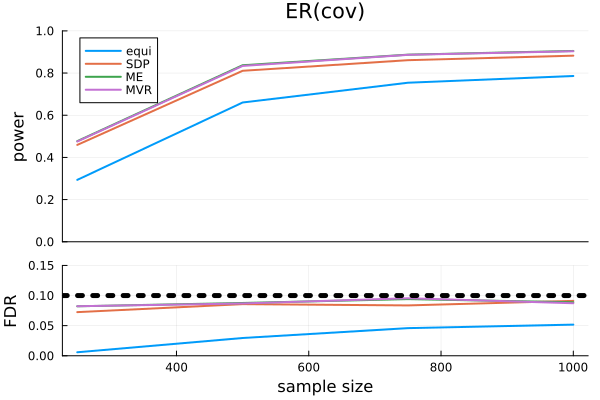

In [3]:
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
gr(fmt=:png);

function summarize_er(cov::Bool; ns = 250:250:1000)
    dir = cov ? "/home/groups/sabatti/group_knockoff_simulations/ER_cov" :
        "/home/groups/sabatti/group_knockoff_simulations/ER_prec"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for n in ns
        success = 0
        # df is a single simulation with fixed gamma
        df = DataFrame(method=["equi","sdp","maxent","mvr"],
            power=zeros(4), fdr=zeros(4), time=zeros(4), ssum=zeros(4), obj=zeros(4))
        for seed in 1:100
            try
                result = CSV.read(joinpath(dir, "n$n", "sim$seed.csv"), DataFrame)
                df[:, 2:end] .+= result[:, 2:end]                
                success += 1
            catch
                continue
            end
        end
        df[:, 2:end] ./= success
        println("n $n has $success success")
#         @show df
        # save power/FDR result
        push!(equi_powers, df[1, "power"]); push!(equi_fdrs, df[1, "fdr"])
        push!(sdp_powers, df[2, "power"]); push!(sdp_fdrs, df[2, "fdr"])
        push!(maxent_powers, df[3, "power"]); push!(maxent_fdrs, df[3, "fdr"])
        push!(mvr_powers, df[4, "power"]); push!(mvr_fdrs, df[4, "fdr"])
    end
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function make_plot_er(cov::Bool; ns = 250:250:1000)
    # summarize results
    equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
        summarize_er(cov, ns=ns)
    
    # power plot
    title = cov ? "ER(cov)" : "ER(prec)"
    power_plt = plot(ns, equi_powers, xtick=false, title=title,
        ylabel="power", label="equi", w=2, ylim=(0, 1.0))
    plot!(ns, sdp_powers, label = "SDP", w=2)
    plot!(ns, maxent_powers, label = "ME", w=2)
    plot!(ns, mvr_powers, label = "MVR", w=2)
    
    # FDR plots
    fdr_plt = plot(ns, equi_fdrs, xlabel="sample size", 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.15))
    plot!(ns, sdp_fdrs, label = "SDP", w=2)
    plot!(ns, maxent_fdrs, label = "ME", w=2)
    plot!(ns, mvr_fdrs, label = "MVR", w=2)
    hline!(fdr_plt, [0.1], label = "target FDR", linestyle=:dot, w=5, color=:black, legend=false)
    
    return power_plt, fdr_plt
end

ER_cov_power_plt, ER_cov_fdr_plt = make_plot_er(true)
plot(ER_cov_power_plt, ER_cov_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))

n 250 has 74 success
n 500 has 57 success
n 750 has 46 success
n 1000 has 33 success


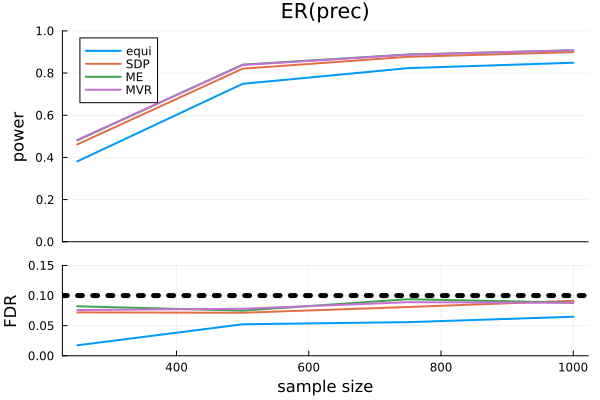

In [4]:
ER_cov_power_plt, ER_cov_fdr_plt = make_plot_er(false)
plot(ER_cov_power_plt, ER_cov_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))